This script is to read DSM2 hdf5 output directly and load it into pandas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import h5py
from pydsm.filter import *
from pydsm.io import *

## Step 1
Reading in the hdf5 file and table output/channel avg concentration into a pandas frame. 
This is a multi-dimensional table so hierarchical indices are needed to accomodate it. 
The attributes for the table contain the start time and time interval and those are used for indexing the first dimension as a datetime

In [2]:
def read_table_as_array(file_path, table_path, dtype=str):
    '''
    reads table from h5 file_path from the table_path and returns array of dtype
    '''
    with h5py.File(file_path,'r') as f:
        return np.array(f[table_path]).astype(dtype)
def read_dsm2_table(file_path, table_path, column_values, column_names, start_time_key='start_time', interval_key='interval'):
    '''
    file_path: Name of h5 file (full path or relative path)
    table_path: Path within the h5 file to the values table e.g. /output/channel_concentrations
    column_values: Values used for the 2nd and 3rd dimension of table. 
        For DSM2 the 2nd dimension is the variable dimension (flow, stage, constituent)
                 the 3rd dimension is the location dimension (channel, reservoir)
                 Time is always assumed to be the first dimension in the table
    column_names: Names for the 2nd and 3rd dimensions
    '''
    with h5py.File(file_path,'r') as f:
        v=f[table_path]
        a=v.attrs
        start_time=a[start_time_key].astype(str)[0]
        interval=a[interval_key].astype(str)[0]
        vals=np.array(v)
    c1=column_values[0]
    c2=column_values[1]
    x1=c1.repeat(c2.size)
    x2=c2.repeat(c1.size)
    vi=pd.MultiIndex.from_arrays([x1,x2],names=tuple(column_names))
    vti=pd.DatetimeIndex(data=pd.date_range(start=start_time,freq=interval,periods=vals.shape[0])
            ,name="Time")
    return pd.DataFrame(data=vals.reshape(vals.shape[0],vals.shape[1]*vals.shape[2]),index=vti,columns=vi)
def generate_godin_fir(timeinterval='1hour'):
    '''
    generate godin filter impulse response for given timeinterval
    '''
    mins=pd.Timedelta(timeinterval).seconds/60 # FIXME: needs mins_in_interval function
    wts24=np.zeros(round(24*60/mins))
    wts24[:]=1/wts24.size
    tidal_period=round(24.75*60/mins)
    if tidal_period%2==0: tidal_period=tidal_period+1
    wts25=np.zeros(tidal_period)
    wts25[:]=1.0/wts25.size
    return np.convolve(wts25,np.convolve(wts24,wts24))
def godin_filter(df,timeinterval='15min'):
    '''
    return godin filtered values for data frame values
    '''
    godin_ir=generate_godin_fir(timeinterval)
    dfg=pd.DataFrame(np.convolve(df.values,godin_ir,mode='same'))
    dfg.index=df.index
    return dfg

In [8]:
filename='../data/output/historical_v82_ec.h5'
na1=read_table_as_array(filename,'output/constituent_names')
na2=read_table_as_array(filename, 'output/channel_number',dtype=int)
#print(na1,na2)
df=read_dsm2_table(filename,'output/channel avg concentration',[na1,na2],['constituent','channel'])
#display(df)

In [9]:
import json
with open('dsm2-flowpolygons.geojson') as f: dsm2_grid=json.load(f)
for g in dsm2_grid['features']: g['id']=int(g['properties']['channel_nu'])

In [10]:
#

In [11]:
import ipyleaflet
from IPython.display import display
import ipywidgets as widgets
from branca.colormap import linear

## Map 
<font color=red>Warning: Geojson with polygons for channels is needed!</font>

In [12]:
max_time_steps=len(df.index)
constituent_names=na1
#
def extract_constituent_as_dict(df, timestep=0,constituent_name='ec'):
    tblx=df.iloc[timestep][constituent_name,slice(None)]
    return tblx.to_dict()
tbl0=extract_constituent_as_dict(df,100,'ec')
#
import matplotlib
import matplotlib.ticker
def make_nice_rounded_range(min,max,steps=10):
    l = matplotlib.ticker.AutoLocator()
    l.create_dummy_axis()
    x=l.tick_values(min,max)
    return x[0],x[-1]
#
layer = ipyleaflet.Choropleth(
    geo_data=dsm2_grid,
    choro_data=tbl0,
    value_min=100,
    value_max=25000,
    colormap=linear.Spectral_11, #linear.YlOrRd_04,
    style={'fillOpacity': 1.0})
#
def update_legend():
    # add legend
    v=layer.choro_data.values()
    r=make_nice_rounded_range(min(v),max(v))
    legend=linear.RdBu_11.scale(r[0],r[1])
    layer.colormap=legend
    out.clear_output()
    with out:
        display(legend)

def handle_slider_change(change):
    print(change.new)
    layer.choro_data=extract_constituent_as_dict(df,change.new, constituent_selector.value)
    
def handle_dropdown_change(change):
    layer.choro_data=extract_constituent_as_dict(df,slider.value, constituent_selector.value)
    update_legend()

#
m = ipyleaflet.Map(center = (38,-121), zoom = 11)
m.add_layer(layer)
m.add_control(ipyleaflet.FullScreenControl())
#add slider control
slider = widgets.IntSlider(min=0, max=max_time_steps, continuous_update=False)
slider.value = 0
slider.observe(handle_slider_change, names='value')
play = widgets.Play(
    value=0,
    interval=5000,
    min=0,
    max=max_time_steps,
    step=1,
    description="Press play",
    disabled=False
)
widgets.jslink((play, 'value'), (slider, 'value'))
constituents=constituent_names
constituent_selector=widgets.Dropdown(
    options=constituents,
    value='ec',
    description='Constituent:',
    disabled=False,
)
constituent_selector.observe(handle_dropdown_change, names='value')
#
#
control_widget=widgets.HBox([play, slider])
control_widget=widgets.VBox([constituent_selector,control_widget])
widget_control = ipyleaflet.WidgetControl(widget=control_widget, position='bottomright')
m.add_control(widget_control)
out = widgets.Output(layout={'border': '1px solid black'})
update_legend()
widget_control2 = ipyleaflet.WidgetControl(widget=out, position='topright')
m.add_control(widget_control2)
display(m)
#
#
#%matplotlib notebook
widget_output = widgets.Output(layout={'border': '1px solid black'})
def handle_click(**kwargs):
    if not 'id' in kwargs: return
    widget_output.clear_output(wait=True)
    cell_id=kwargs['id']
    with widget_output:
        p=kwargs['properties']
        for k in p:
            if k == 'id' or k == 'style': continue
            display(str(k)+' : '+str(p[k]))
        fig1, axes1 = plt.subplots()
        axes1.set_title(str(constituent_selector.value) + ' for ' + str(cell_id))
        axes1.set_ylabel(str(constituent_selector.value))
        #line1=axes1.axvline(x=slider.value,color='grey')
        #slider.observe(handle_line_)
        godin_filter(df.loc[:,(constituent_selector.value, cell_id)],'1hour').plot(kind='line',ax = axes1)
        plt.show(fig1)
layer.on_click(handle_click)
display(widget_output)

//anaconda3/envs/dsm2/lib/python3.7/site-packages/traitlets/traitlets.py:567: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

Output(layout=Layout(border='1px solid black'))

478
591


In [14]:
for i in range(100): extract_constituent_as_dict(df,i, 'ec')

In [15]:
mtz_to_chipps=[441,440,452,438,443,437]
#ecdf['ec'][mtz_to_chipps]
mtzec=df['ec'][441]

In [16]:
mtzecg=godin_filter(mtzec)

<IPython.core.display.Javascript object>


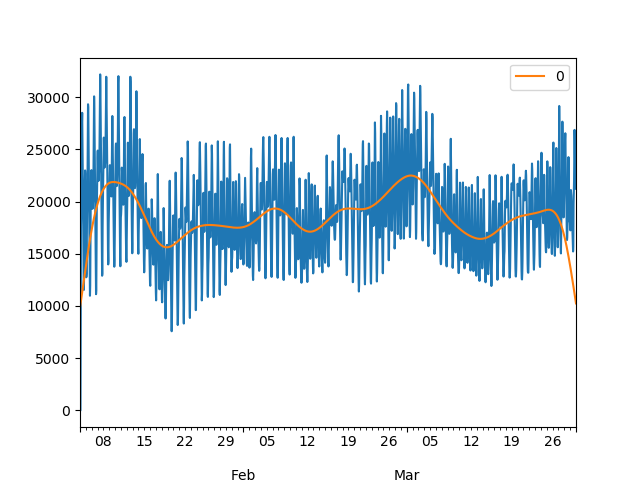

In [17]:
%matplotlib notebook
axes1=mtzec.plot()
mtzecg.plot(ax=axes1)

In [18]:
mtzec_daily=mtzec.resample('D').mean()
mtzecg_daily=mtzecg.resample('D').mean()
display(len(mtzecg_daily),len(mtzec_daily))

86

86